### Import Packages

In [ ]:
# set the seed for reproducibility
import tensorflow as tf
tf.keras.utils.set_random_seed(42)

# import the necessary packages
from tensorflow.keras.layers import TextVectorization
from tensorflow.keras import layers
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
from tensorflow import keras
import string
import pickle
import re
import os

### Define the configuration of the architecture

In [ ]:
class Config:
	# define the dataset path
	DATASET_PATH = "imdb_dataset"

	# define the batch size and buffer size for the dataset pipeline
	BATCH_SIZE = 1024
	BUFFER_SIZE = BATCH_SIZE * 2

	# define the maximum vocabulary size and maximum sequence length
	# for the text vectorization layer
	VOCAB_SIZE = 20_000
	MAX_SEQUENCE_LENGTH = 50

	# define the number of epochs for training
	EPOCHS = 10

	# define the learning rate of the optimizer
	LR = 1e-4

	# define the output path and the path to the saved model and text
	# vectorization layer
	OUTPUT_PATH = "output"
	RNN_MODEL_PATH = os.path.join(OUTPUT_PATH, "rnn_model")
	LSTM_MODEL_PATH = os.path.join(OUTPUT_PATH, "lstm_model")
	TEXT_VEC_PATH = os.path.join(OUTPUT_PATH, "text_vec")

	# define the loss and accuracy plot paths
	RNN_PLOT = os.path.join(OUTPUT_PATH, "rnn_plot.png")
	LSTM_PLOT = os.path.join(OUTPUT_PATH, "lstm_plot.png")

config = Config()

### Dataset download and preprocess

In [ ]:
def get_imdb_dataset(folderName, batchSize, bufferSize, autotune,
	test=False):
	# check whether the test flag is true
	if test:
		# load the test dataset, batch it, and prefetch it
		testDs = tfds.load(
			name="imdb_reviews",
			data_dir=folderName,
			as_supervised=True,
			shuffle_files=True,
			split="test"
		)
		testDs = testDs.batch(batchSize).prefetch(autotune)

		# return the test dataset
		return testDs
	# otherwise we will be loading the training and validation dataset
	else:
		# load the training and validation dataset
		(trainDs, valDs) = tfds.load(
			name="imdb_reviews",
			data_dir=folderName,
			as_supervised=True,
			shuffle_files=True,
			split=["train[:90%]", "train[90%:]"]
		)

		# shuffle, batch, and prefetch the train and the validation
		# dataset
		trainDs = (trainDs
			.shuffle(bufferSize)
			.batch(batchSize)
			.prefetch(autotune)
		)
		valDs = (valDs
			.shuffle(bufferSize)
			.batch(batchSize)
			.prefetch(autotune)
		)

		# return the train and the validation dataset
		return (trainDs, valDs)

In [ ]:
# get the IMDB dataset
print("[INFO] getting the IMDB dataset...")
(trainDs, valDs) = get_imdb_dataset(folderName=config.DATASET_PATH,
	batchSize=config.BATCH_SIZE, bufferSize=config.BUFFER_SIZE,
	autotune=tf.data.AUTOTUNE, test=False)

[INFO] getting the IMDB dataset...


Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Generating splits...:   0%|          | 0/3 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/25000 [00:00<?, ? examples/s]

Shuffling imdb_dataset/imdb_reviews/plain_text/1.0.0.incompleteHBRPOI/imdb_reviews-train.tfrecord*...:   0%|  …

Generating test examples...:   0%|          | 0/25000 [00:00<?, ? examples/s]

Shuffling imdb_dataset/imdb_reviews/plain_text/1.0.0.incompleteHBRPOI/imdb_reviews-test.tfrecord*...:   0%|   …

Generating unsupervised examples...:   0%|          | 0/50000 [00:00<?, ? examples/s]

Shuffling imdb_dataset/imdb_reviews/plain_text/1.0.0.incompleteHBRPOI/imdb_reviews-unsupervised.tfrecord*...: …

Dataset imdb_reviews downloaded and prepared to imdb_dataset/imdb_reviews/plain_text/1.0.0. Subsequent calls will reuse this data.


In [ ]:
def custom_standardization(inputData):
	# transform everything to lower case
	lowercase = tf.strings.lower(inputData)

	# strip off the html break point and punctuations and return it
	strippedHtml = tf.strings.regex_replace(lowercase, "<br />", " ")
	strippedPunctuation = tf.strings.regex_replace(strippedHtml,
		f"[{re.escape(string.punctuation)}]", "")
	return strippedPunctuation

In [ ]:
# initialize the text vectorization layer
vectorizeLayer = layers.TextVectorization(
	max_tokens=config.VOCAB_SIZE,
	output_mode="int",
	output_sequence_length=config.MAX_SEQUENCE_LENGTH,
	standardize=custom_standardization,
)

# grab the text from the training dataset and adapt the text
# vectorization layer on it
trainText = trainDs.map(lambda text, label: text)
vectorizeLayer.adapt(trainText)

# vectorize the training and the validation dataset
trainDs = trainDs.map(lambda text, label: (vectorizeLayer(text), label))
valDs = valDs.map(lambda text, label: (vectorizeLayer(text), label))

### LSTM model

In [ ]:
def get_lstm_model(vocabSize):
	# input for variable-length sequences of integers
	inputs = keras.Input(shape=(None,), dtype="int32")

	# embed the tokens in a 128-dimensional vector with masking
	# applied and apply dropout
	x = layers.Embedding(vocabSize, 128, mask_zero=True)(inputs)
	x = layers.Dropout(0.2)(x)

	# add 3 LSTMs
	x = layers.LSTM(64, return_sequences=True)(x)
	x = layers.LSTM(64, return_sequences=True)(x)
	x = layers.LSTM(64)(x)

	# add a classifier head
	x = layers.Dense(units=64, activation="relu")(x)
	x = layers.Dense(units=32, activation="relu")(x)
	x = layers.Dropout(0.2)(x)
	outputs = layers.Dense(1, activation="sigmoid")(x)

	# build the LSTM model
	model = keras.Model(inputs, outputs, name="LSTM")

	# return the LSTM model
	return model

In [ ]:
# get the LSTM model and compile it
print("[INFO] building the LSTM model...")
modelLSTM = get_lstm_model(vocabSize=config.VOCAB_SIZE)
modelLSTM.compile(metrics=["accuracy"],
	optimizer=keras.optimizers.Adam(learning_rate=config.LR),
	loss=keras.losses.BinaryCrossentropy(from_logits=False),
)

# train the LSTM model
print("[INFO] training the LSTM model...")
historyLSTM = modelLSTM.fit(trainDs, epochs=config.EPOCHS,
	validation_data=valDs,
)

[INFO] building the LSTM model...
[INFO] training the LSTM model...
Epoch 1/10
22/22 [==============================] - 27s 466ms/step - loss: 0.6931 - accuracy: 0.5056 - val_loss: 0.6930 - val_accuracy: 0.5048
Epoch 2/10
22/22 [==============================] - 7s 320ms/step - loss: 0.6926 - accuracy: 0.5202 - val_loss: 0.6918 - val_accuracy: 0.5548
Epoch 3/10
22/22 [==============================] - 5s 226ms/step - loss: 0.6890 - accuracy: 0.5763 - val_loss: 0.6840 - val_accuracy: 0.5976
Epoch 4/10
22/22 [==============================] - 7s 291ms/step - loss: 0.6651 - accuracy: 0.6370 - val_loss: 0.6379 - val_accuracy: 0.6816
Epoch 5/10
22/22 [==============================] - 5s 222ms/step - loss: 0.6002 - accuracy: 0.7275 - val_loss: 0.5773 - val_accuracy: 0.7184
Epoch 6/10
22/22 [==============================] - 4s 204ms/step - loss: 0.5238 - accuracy: 0.7694 - val_loss: 0.5360 - val_accuracy: 0.7324
Epoch 7/10
22/22 [==============================] - 4s 190ms/step - loss: 0.456

In [ ]:
def plot_loss_accuracy(history, filepath):
	# plot the training and validation loss
	plt.style.use("ggplot")
	(fig, axs) = plt.subplots(2, 1)
	axs[0].plot(history["loss"], label="train_loss")
	axs[0].plot(history["val_loss"], label="val_loss")
	axs[0].set_xlabel("Epoch #")
	axs[0].set_ylabel("Loss")
	axs[0].legend()
	axs[1].plot(history["accuracy"], label="train_accuracy")
	axs[1].plot(history["val_accuracy"], label="val_accuracy")
	axs[1].set_xlabel("Epoch #")
	axs[1].set_ylabel("Accuracy")
	axs[1].legend()
	fig.savefig(filepath)

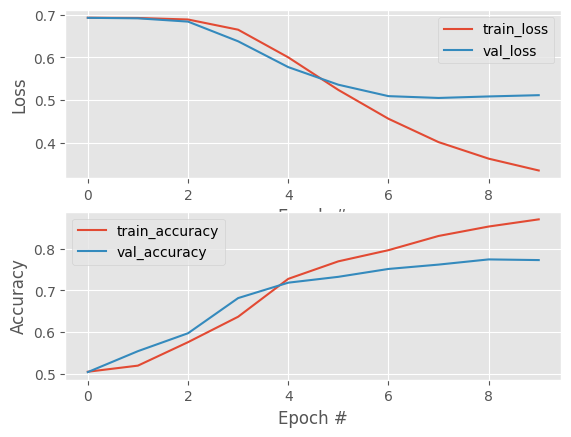

In [ ]:
# check whether the output folder exists, if not build the output folder
if not os.path.exists(config.OUTPUT_PATH):
	os.makedirs(config.OUTPUT_PATH)

# save the loss and accuracy plots of RNN and LSTM models
plot_loss_accuracy(history=historyLSTM.history, filepath=config.LSTM_PLOT)

### Save the model and vectorization layer

In [ ]:
def save_vectorizer(vectorizer, name):
	# pickle the weights of the vectorization layer
	pickle.dump({"weights": vectorizer.get_weights()},
		open(f"{name}.pkl", "wb"))

In [ ]:
print(f"[INFO] saving the LSTM model to {config.LSTM_MODEL_PATH}...")
keras.models.save_model(model=modelLSTM, filepath=config.LSTM_MODEL_PATH,
	include_optimizer=False)

# save the text vectorization layer to disk
save_vectorizer(vectorizer=vectorizeLayer, name=config.TEXT_VEC_PATH)

[INFO] saving the LSTM model to output/lstm_model...


### Infer on the saved model

In [ ]:
def load_vectorizer(name, maxTokens, outputLength, standardize=None):
	# load the pickles data
	fromDisk = pickle.load(open(f"{name}.pkl", "rb"))

	# build a new vectorization layer
	newVectorizer = TextVectorization(max_tokens=maxTokens,
		output_mode="int", output_sequence_length=outputLength,
		standardize=standardize)

	# call the adap method with some dummy data for the vectorization
	# layer to initialize properly
	newVectorizer.adapt(tf.data.Dataset.from_tensor_slices(["xyz"]))
	newVectorizer.set_weights(fromDisk["weights"])

	# return the vectorization layer
	return newVectorizer

In [ ]:
print("[INFO] loading the pre-trained LSTM model...")
modelLstm = keras.models.load_model(filepath=config.LSTM_MODEL_PATH)
modelLstm.compile(optimizer="adam", metrics=["accuracy"],
	loss=keras.losses.BinaryCrossentropy(from_logits=False),
)

# get the IMDB dataset
print("[INFO] getting the IMDB test dataset...")
testDs = get_imdb_dataset(folderName=config.DATASET_PATH,
	batchSize=config.BATCH_SIZE, bufferSize=config.BUFFER_SIZE,
	autotune=tf.data.AUTOTUNE, test=True)

# load the pre-trained text vectorization layer
vectorizeLayer = load_vectorizer(name=config.TEXT_VEC_PATH,
	maxTokens=config.VOCAB_SIZE,
	outputLength=config.MAX_SEQUENCE_LENGTH,
	standardize=custom_standardization)

[INFO] loading the pre-trained LSTM model...


[INFO] getting the IMDB test dataset...


In [ ]:
# vectorize the test dataset
testDs = testDs.map(lambda text, label: (vectorizeLayer(text), label))

# evaluate the trained RNN and LSTM model on the test dataset
model = modelLstm
print(f"[INFO] test evaluation for {model.name}:")
(testLoss, testAccuracy) = model.evaluate(testDs)
print(f"\t[INFO] test loss: {testLoss:0.2f}")
print(f"\t[INFO] test accuracy: {testAccuracy * 100:0.2f}%")

[INFO] test evaluation for LSTM:
25/25 [==============================] - 9s 70ms/step - loss: 0.5642 - accuracy: 0.7426
	[INFO] test loss: 0.56
	[INFO] test accuracy: 74.26%
